# Chapter 5 - Classification

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression #, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score

import statsmodels.api as sm

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from pygam import LinearGAM, s, f, l

from dmba import classificationSummary

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Naive Bayes
    The naive Bayes algorithm uses the probability of observing predictor values, given an outcome, to estimate what is really of interest: the probability of observing outcome Y = i, given a set of predictor values.
### The Naive Solution

In [4]:
# Load the CSV data into a DataFrame
url1 = ('https://raw.githubusercontent.com/arvindbetrabet/Practical_Statistics_for_Data_Scientists/refs/heads/master/data/loan_data.csv')  
loan_data = pd.read_csv(url1)

loan_data.head()

,Unnamed: 0,status,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,...,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_,borrower_score
0,1,Charged Off,2500,60 months,30000,1.00,2.39320,1687,9.4,car,...,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year,0.65
1,2,Charged Off,5600,60 months,40000,5.55,4.57170,5210,32.6,small_business,...,1,1,11,1.4,default,5,small_business,OWN,> 1 Year,0.80
2,3,Charged Off,5375,60 months,15000,18.08,9.71600,9279,36.5,other,...,1,1,2,6.0,default,1,other,RENT,> 1 Year,0.60
3,4,Charged Off,9000,36 months,30000,10.08,12.21520,10452,91.7,debt_consolidation,...,1,1,4,4.2,default,1,debt_consolidation,RENT,> 1 Year,0.50
4,5,Charged Off,10000,36 months,100000,7.06,3.90888,11997,55.5,other,...,1,1,14,5.4,default,4,other,RENT,> 1 Year,0.55


In [5]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45342 entries, 0 to 45341
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         45342 non-null  int64  
 1   status             45342 non-null  object 
 2   loan_amnt          45342 non-null  int64  
 3   term               45342 non-null  object 
 4   annual_inc         45342 non-null  int64  
 5   dti                45342 non-null  float64
 6   payment_inc_ratio  45342 non-null  float64
 7   revol_bal          45342 non-null  int64  
 8   revol_util         45342 non-null  float64
 9   purpose            45342 non-null  object 
 10  home_ownership     45342 non-null  object 
 11  delinq_2yrs_zero   45342 non-null  int64  
 12  pub_rec_zero       45342 non-null  int64  
 13  open_acc           45342 non-null  int64  
 14  grade              45342 non-null  float64
 15  outcome            45342 non-null  object 
 16  emp_length         453

In [6]:
# Convert categorical columns to 'category' data type
loan_data.outcome = loan_data.outcome.astype('category')           # Convert 'outcome' to categorical
loan_data.outcome.cat.reorder_categories(['paid off', 'default'])  # Reorder the categories for 'outcome'
loan_data.purpose_ = loan_data.purpose_.astype('category')         # Convert 'purpose_' to categorical
loan_data.home_ = loan_data.home_.astype('category')               # Convert 'home_' to categorical
loan_data.emp_len_ = loan_data.emp_len_.astype('category')         # Convert 'emp_len_' to categorical

# Define predictors and outcome variable
predictors = ['purpose_', 'home_', 'emp_len_']  # List of predictor variables
outcome = 'outcome'                             # Define the outcome variable

# Convert categorical predictors to dummy variables for model training
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='', dtype=int)  # Create dummy variables from categorical features
y = loan_data[outcome]                                                          # Set the target variable (outcome)

# Define and train the Naive Bayes model
naive_model = MultinomialNB(alpha=0.01, fit_prior=True)      # Create a Naive Bayes model with alpha = 0.01 and using class priors
naive_model = MultinomialNB(alpha=1e-10, fit_prior=False)    # Update the model with a new alpha (almost no smoothing) and no priors
naive_model.fit(X, y)                                        # Fit the model with the predictors and outcome

# Make a prediction for a specific loan (index 146)
new_loan = X.loc[146:146, :]                                 # Select the 146th row from predictors DataFrame
print('predicted class: ', naive_model.predict(new_loan)[0]) # Print the predicted class for the new loan
print()

# Calculate the predicted probabilities for the selected loan
probabilities = pd.DataFrame(naive_model.predict_proba(new_loan),
                             columns=naive_model.classes_)   # Create DataFrame for predicted probabilities

print('predicted probabilities')  # Print label for predicted probabilities
probabilities                     # Print the predicted probabilities

predicted class:  default

predicted probabilities


,default,paid off
0,0.653699,0.346301


In [7]:
# Make a prediction for a specific loan (index 5422)
new_loan = X.loc[5422:5422, :]                                # Select the 5422nd row from predictors DataFrame
print('predicted class: ', naive_model.predict(new_loan)[0])  # Print the predicted class for the new loan
print()

# Calculate the predicted probabilities for the selected loan
probabilities = pd.DataFrame(naive_model.predict_proba(new_loan),
                             columns=naive_model.classes_)    # Create DataFrame for predicted probabilities

print('predicted probabilities')  # Print label for predicted probabilities
probabilities                     # Print the predicted probabilities

predicted class:  paid off

predicted probabilities


,default,paid off
0,0.413131,0.586869


# Discriminant Analysis

#### When to Use LDA in Real Life?
* **Balanced, normally distributed datasets:** When your data has normally distributed features with similar covariance and balanced classes.
* **Multiclass classification:** LDA handles multiclass problems efficiently and provides interpretability.
* **Dimensionality reduction:** LDA is effective for reducing dimensions while preserving information related to class separation.
* **Small datasets:** When the dataset is small compared to the number of features, LDA can still produce meaningful results.
* **Interpretability:** If you need a simple, interpretable model with linear decision boundaries.
* **Incorporating prior knowledge:** If you have knowledge about prior probabilities of the classes.

### A Simple Example

In [9]:
# Load the CSV data into a DataFrame
url2 = ('https://raw.githubusercontent.com/arvindbetrabet/Practical_Statistics_for_Data_Scientists/refs/heads/master/data/loan3000.csv')  
loan3000 = pd.read_csv(url2)

loan3000.head()

,Unnamed: 0,outcome,purpose_,dti,borrower_score,payment_inc_ratio
0,32109,paid off,debt_consolidation,21.23,0.40,5.11135
1,16982,default,credit_card,15.49,0.40,5.43165
2,25335,paid off,debt_consolidation,27.30,0.70,9.23003
3,34580,paid off,major_purchase,21.11,0.40,2.33482
4,14424,default,debt_consolidation,16.46,0.45,12.10320


In [10]:
loan3000.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         3000 non-null   int64  
 1   outcome            3000 non-null   object 
 2   purpose_           3000 non-null   object 
 3   dti                3000 non-null   float64
 4   borrower_score     3000 non-null   float64
 5   payment_inc_ratio  3000 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 140.8+ KB


In [11]:
# Convert 'outcome' to categorical type
loan3000.outcome = loan3000.outcome.astype('category') 

# Define predictors and outcome variable
predictors = ['borrower_score', 'payment_inc_ratio'] 
outcome = 'outcome'

# Extract predictors and outcome from the DataFrame
X = loan3000[predictors]
y = loan3000[outcome]

# Define and fit the Linear Discriminant Analysis (LDA) model
loan_lda = LinearDiscriminantAnalysis()  # Create an instance of Linear Discriminant Analysis
loan_lda.fit(X, y)                       # Fit the LDA model to the predictors (X) and target variable (y)

# Print the scaling coefficients used in LDA for dimension reduction
pd.DataFrame(loan_lda.scalings_, index=X.columns)  # Display the LDA scalings for each predictor

,0
borrower_score,7.175839
payment_inc_ratio,-0.099676


This represent the weights that each predictor contributes to the discriminant function. These coefficients are essentially the linear combination of features that LDA uses to create the discriminant function, which is the function that best separates the classes (outcome).

`borrower_score (Coefficient = 7.175839)`: This value indicates that borrower_score has a positive impact on the discriminant function, and it is a strong determinant of class separation. This means that as borrower_score increases, it significantly influences the decision boundary created by LDA, likely indicating a higher chance of paid off.

`payment_inc_ratio (Coefficient = -0.099676)`: The coefficient for payment_inc_ratio is negative and much smaller in magnitude compared to borrower_score. A negative value suggests that as payment_inc_ratio increases, it contributes negatively to the discriminant function. Since the magnitude is relatively small (only -0.10), it indicates that this feature plays a minor role compared to borrower_score in separating the classes. 

In [13]:
# Predict class probabilities for each observation in loan3000
pred = pd.DataFrame(loan_lda.predict_proba(loan3000[predictors]), 
                    columns=loan_lda.classes_)

# Display the first 5 rows of the predicted probabilities
pred.head()

,default,paid off
0,0.553544,0.446456
1,0.558953,0.441047
2,0.272696,0.727304
3,0.506254,0.493746
4,0.609952,0.390048


Each Row Represents an Observation. For each observation, there are two values—one for the probability of default and the other for paid off.

### Decision Boundary

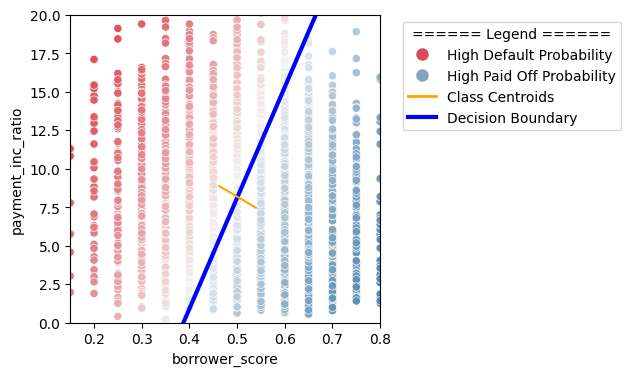

In [16]:
# Use scalings and center of means to determine decision boundary
center = np.mean(loan_lda.means_, axis=0)  # Calculate the center of the means for both classes to find the overall centroid

# Calculate the slope and intercept for the decision boundary
slope = - loan_lda.scalings_[0] / loan_lda.scalings_[1]  # Slope of the decision boundary using LDA scalings (negative ratio of scalings)
intercept = center[1] - center[0] * slope                # Intercept calculated based on the center (mean point) and slope

# Determine payment_inc_ratio values for borrower_score of 0 and 20
x_0 = (0 - intercept) / slope    # Calculate y-coordinate when borrower_score is 0
x_20 = (20 - intercept) / slope  # Calculate y-coordinate when borrower_score is 20

# Create a DataFrame by combining loan data with predicted probabilities for 'default'
lda_df = pd.concat([loan3000, pred['default']], axis=1)  # Concatenate the 'default' probability column with the original loan data

# Create a plot
fig, ax = plt.subplots(figsize=(4, 4))  # Create a figure and axis with size 4x4 inches for the plot

# Scatter plot of borrower_score vs. payment_inc_ratio, color-coded by the probability of default
g = sns.scatterplot(x='borrower_score', y='payment_inc_ratio',
                    hue='default', data=lda_df,                                 # Color points based on 'default' probabilities
                    palette=sns.diverging_palette(240, 10, n=9, as_cmap=True),  # Use a diverging color palette
                    ax=ax)                                                      # Plot points on the given axis

# Set axis limits for better visualization
ax.set_ylim(0, 20)      # Limit y-axis values to 0-20
ax.set_xlim(0.15, 0.8)  # Limit x-axis values to 0.15-0.8

# Plot the decision boundary using the calculated points (x_0 and x_20)
ax.plot((x_0, x_20), (0, 20), linewidth=3, color='blue', label='Decision Boundary')  # Plot the decision boundary line between points for 
                                                                                     # borrower_score = 0 and 20

# Plot the mean points for each class from LDA
ax.plot(*loan_lda.means_.transpose(), color='orange', label='Class Centroids')  # Plot the means (centroids) of each class on the scatter plot

# Adding custom legend outside the plot
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#D94B5A', markersize=10, label='High Default Probability'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#7FA6C0', markersize=10, label='High Paid Off Probability'),
    plt.Line2D([0], [0], color='orange', lw=2, label='Class Centroids'),
    plt.Line2D([0], [0], color='blue', lw=3, label='Decision Boundary')
]
ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1.05, 1), title="====== Legend ======")

# Display Graph
plt.show()

In [17]:
loan3000.head()

,Unnamed: 0,outcome,purpose_,dti,borrower_score,payment_inc_ratio
0,32109,paid off,debt_consolidation,21.23,0.40,5.11135
1,16982,default,credit_card,15.49,0.40,5.43165
2,25335,paid off,debt_consolidation,27.30,0.70,9.23003
3,34580,paid off,major_purchase,21.11,0.40,2.33482
4,14424,default,debt_consolidation,16.46,0.45,12.10320


# Logistic Regression

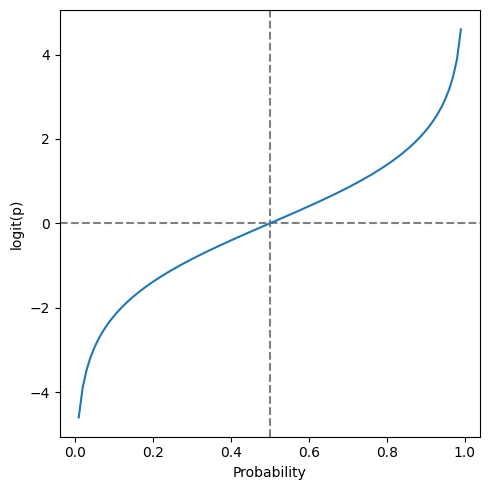

In [19]:
p = np.arange(0.01, 1, 0.01)
df = pd.DataFrame({
    'p': p,
    'logit': np.log(p / (1 - p)),
    'odds': p / (1 - p),
})

fig, ax = plt.subplots(figsize=(5, 5))
ax.axhline(0, color='grey', linestyle='--')
ax.axvline(0.5, color='grey', linestyle='--')
ax.plot(df['p'], df['logit'])
ax.set_xlabel('Probability')
ax.set_ylabel('logit(p)')

plt.tight_layout()
plt.show()

## Logistic Regression and the Generalized Linear Models (GLMs) 

In [21]:
# Define predictor variables (features) and outcome variable
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_', 'borrower_score']  # Select relevant features for the model
outcome = 'outcome'                                                                    # Define the target variable representing the loan outcome

# Create a design matrix with dummy variables for categorical predictors
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='',   # Use dummy variables for categorical features without adding prefix
                   drop_first=True, dtype=int)   # Drop the first category to avoid collinearity and use integer type for efficiency
y = loan_data[outcome]  # Assign the outcome variable for logistic regression

# Instantiate and fit a logistic regression model
logit_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')  # Create a model with a high value for 'C' (almost no regularization)
logit_reg.fit(X, y)  # Fit the model to the data

print('intercept:', logit_reg.intercept_[0])   # Print the intercept of the fitted model
print('classes:', logit_reg.classes_)          # Print the classes that are being predicted
print()

# Create a DataFrame to display the model coefficients for each predictor
pd.DataFrame({'coeff': logit_reg.coef_[0]}, 
             index=X.columns)  # Create a DataFrame with predictor coefficients, indexed by feature names to show their impact

intercept: -1.6380884747585258
classes: ['default' 'paid off']



,coeff
payment_inc_ratio,-0.079728
borrower_score,4.611037
debt_consolidation,-0.249342
home_improvement,-0.407614
major_purchase,-0.229375
medical,-0.510087
other,-0.620534
small_business,-1.215662
OWN,-0.048452
RENT,-0.157355


In [22]:
# Combine features with the target variable
combined_df = pd.concat([X, y], axis=1)

combined_df.head()

,payment_inc_ratio,borrower_score,debt_consolidation,home_improvement,major_purchase,medical,other,small_business,OWN,RENT,> 1 Year,outcome
0,2.39320,0.65,0,0,1,0,0,0,0,1,1,default
1,4.57170,0.80,0,0,0,0,0,1,1,0,1,default
2,9.71600,0.60,0,0,0,0,1,0,0,1,1,default
3,12.21520,0.50,1,0,0,0,0,0,0,1,1,default
4,3.90888,0.55,0,0,0,0,1,0,0,1,1,default


In [23]:
print(loan_data['purpose_'].cat.categories)
print(loan_data['home_'].cat.categories)
print(loan_data['emp_len_'].cat.categories)

Index(['credit_card', 'debt_consolidation', 'home_improvement',
       'major_purchase', 'medical', 'other', 'small_business'],
      dtype='object')
Index(['MORTGAGE', 'OWN', 'RENT'], dtype='object')
Index([' < 1 Year', ' > 1 Year'], dtype='object')


**Not in book:** If you have a feature or outcome variable that is ordinal, use the scikit-learn `OrdinalEncoder` to replace the categories (here, 'paid off' and 'default') with numbers. In the below code, we replace 'paid off' with 0 and 'default' with 1. This reverses the order of the predicted classes and as a consequence, the coefficients will be reversed.

In [25]:
from sklearn.preprocessing import OrdinalEncoder

# Encode the outcome variable into numeric form using an ordinal scale
enc = OrdinalEncoder(categories=[['paid off', 'default']])  # 'paid off' is encoded as 0 and 'default' as 1
y_enc = enc.fit_transform(loan_data[[outcome]]).ravel()     # Fit and transform the 'outcome' column, then flatten to a 1D array for model fitting

# Create and fit a logistic regression model with L2 regularization
logit_reg_enc = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')  # Instantiate Logistic Regression with L2 regularization
logit_reg_enc.fit(X, y_enc)   # Fit the model using predictors (X) and the encoded target variable (y_enc)

# Print the intercept of the logistic regression model
print('intercept ', logit_reg_enc.intercept_[0])  # Output the intercept (bias) of the logistic regression model

# Print the classes in the model
print('classes', logit_reg_enc.classes_)  # Output the classes that the model is predicting

# Create a DataFrame of the coefficients for each feature
pd.DataFrame({'coeff': logit_reg_enc.coef_[0]}, 
             index=X.columns)  # Create a DataFrame of model coefficients for each predictor, with feature names as the index

intercept  1.6378907115404544
classes [0. 1.]


,coeff
payment_inc_ratio,0.079739
borrower_score,-4.612183
debt_consolidation,0.249414
home_improvement,0.407734
major_purchase,0.229710
medical,0.510744
other,0.620800
small_business,1.214936
OWN,0.048211
RENT,0.157288


# Predicted Values from Logistic Regression

The log probabilities are used when we want to avoid numerical issues with very small probability values, which can occur when using regular probabilities directly.

In [28]:
# Generate predicted log probabilities for each observation in the dataset
pred = pd.DataFrame(logit_reg.predict_log_proba(X),  # Predict the log probabilities of each class for each observation in X
                    columns=logit_reg.classes_)      # Assign class names as column labels for better interpretability

# Display a summary of the predicted log probabilities for each class
pred.describe()  # Show descriptive statistics (mean, min, max, etc.) for the predicted log probabilities

,default,paid off
count,45342.000000,45342.000000
mean,-0.757850,-0.760423
std,0.378032,0.390419
min,-2.768873,-3.538864
25%,-0.985728,-0.977164
50%,-0.697366,-0.688946
75%,-0.472209,-0.467076
max,-0.029476,-0.064787


In [29]:
# Generate predicted probabilities for each observation in the dataset
pred = pd.DataFrame(logit_reg.predict_proba(X),  # Predict the probabilities for each class ('paid off' and 'default') for every observation in X
                    columns=logit_reg.classes_)  # Assign class names as column labels for interpretability

# Display a summary of the predicted probabilities for each class
pred.describe()  # Show descriptive statistics (mean, min, max, etc.) for the predicted probabilities

,default,paid off
count,45342.000000,45342.000000
mean,0.500001,0.499999
std,0.167336,0.167336
min,0.062733,0.029046
25%,0.373167,0.376377
50%,0.497895,0.502105
75%,0.623623,0.626833
max,0.970954,0.937267


The fact that the mean is close to 0.5 suggests that the model struggles to make confident predictions.

The distribution of predicted probabilities shows that the model mostly assigns values within a moderate range. It rarely gives predictions that are very close to 0 or 1, which indicates a lack of strong classification in most cases.

# Interpreting the Coefficients and Odds Ratios

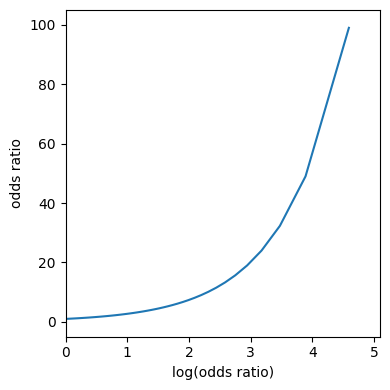

In [32]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.plot(df['logit'], df['odds'])
ax.set_xlabel('log(odds ratio)')
ax.set_ylabel('odds ratio')
ax.set_xlim(0, 5.1)
ax.set_ylim(-5, 105)

plt.tight_layout()
plt.show()

In [33]:
df

,p,logit,odds
0,0.01,-4.595120,0.010101
1,0.02,-3.891820,0.020408
2,0.03,-3.476099,0.030928
3,0.04,-3.178054,0.041667
4,0.05,-2.944439,0.052632
...,...,...,...
94,0.95,2.944439,19.000000
95,0.96,3.178054,24.000000
96,0.97,3.476099,32.333333
97,0.98,3.891820,49.000000


# Assessing the Model

In [35]:
# Convert categorical outcome to numerical representation
y_numbers = [1 if yi == 'default' else 0 for yi in y]  # Encode the outcome variable as binary: 'default' = 1, 'paid off' = 0

# Create a Generalized Linear Model (GLM) for logistic regression
logit_reg_sm = sm.GLM(y_numbers, X.assign(const=1),    # Assign X with an intercept column to include the constant term
                      family=sm.families.Binomial())   # Specify the family as Binomial to perform logistic regression

# Fit the GLM model
logit_result = logit_reg_sm.fit()  # Fit the logistic regression model to the data

# Print the summary of the model
print(logit_result.summary())      # Display a detailed summary of the fitted model, including coefficients and statistics

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                45342
Model:                            GLM   Df Residuals:                    45330
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28757.
Date:                Fri, 29 Nov 2024   Deviance:                       57515.
Time:                        14:40:32   Pearson chi2:                 4.54e+04
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1112
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
payment_inc_ratio      0.0797      0

#### Notes:

`payment_inc_ratio (0.0797)`: A positive coefficient, indicating that as the income-to-payment ratio increases, the probability of default increases slightly. It’s statistically significant (p-value < 0.001).

**const == Intercept**

We can use stepwise regression, fit interaction terms, or include spline terms. The same concerns regarding confounding and correlated variables apply to logistic regression

In [38]:
import statsmodels.formula.api as smf

# Define the formula for the GLM with B-splines for specific predictors
formula = ('outcome ~ bs(payment_inc_ratio, df=8) + purpose_ + ' +
           'home_ + emp_len_ + bs(borrower_score, df=3)')  # Define the model formula with splines for non-linear terms

# Create a GLM model using the formula and specify the binomial family for logistic regression
model = smf.glm(formula=formula, data=loan_data, family=sm.families.Binomial())

# Fit the GLM model to the data
results = model.fit()

# Print the model summary with details of fitted coefficients and other metrics
results.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                             Generalized Linear Model Regression Results                             
=====================================================================================================
Dep. Variable:     ['outcome[default]', 'outcome[paid off]']   No. Observations:                45342
Model:                                                   GLM   Df Residuals:                    45321
Model Family:                                       Binomial   Df Model:                           20
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -28731.
Date:                                       Fri, 29 Nov 2024   Deviance:                       57462.
Time:                                               14:40:32   Pearson chi2:                 4.54e+04
No. Iterations:                                            6   Pseudo R-squ. (CS):             0.1122
Covariance Type:                                   nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          1.5756      0.331      4.765      0.000       0.928       2.224
purpose_[T.debt_consolidation]     0.2486      0.028      8.998      0.000       0.194       0.303
purpose_[T.home_improvement]       0.4097      0.047      8.757      0.000       0.318       0.501
purpose_[T.major_purchase]         0.2382      0.054      4.416      0.000       0.132       0.344
purpose_[T.medical]                0.5206      0.087      5.980      0.000       0.350       0.691
purpose_[T.other]                  0.6284      0.040     15.781      0.000       0.550       0.706
purpose_[T.small_business]         1.2250      0.063     19.305      0.000       1.101       1.349
home_[T.OWN]                       0.0498      0.038      1.309      0.191      -0.025       0.124
home_[T.RENT]                      0.1577      0.021      7.431      0.000       0.116       0.199
emp_len_[T. > 1 Year]             -0.3526      0.053     -6.699      0.000      -0.456      -0.249
bs(payment_inc_ratio, df=8)[0]     0.7042      0.342      2.060      0.039       0.034       1.374
bs(payment_inc_ratio, df=8)[1]     0.6621      0.198      3.351      0.001       0.275       1.049
bs(payment_inc_ratio, df=8)[2]     0.8118      0.245      3.309      0.001       0.331       1.293
bs(payment_inc_ratio, df=8)[3]     1.0377      0.223      4.644      0.000       0.600       1.476
bs(payment_inc_ratio, df=8)[4]     1.1901      0.233      5.112      0.000       0.734       1.646
bs(payment_inc_ratio, df=8)[5]     2.8404      0.316      8.980      0.000       2.220       3.460
bs(payment_inc_ratio, df=8)[6]    -1.3427      1.229     -1.092      0.275      -3.752       1.067
bs(payment_inc_ratio, df=8)[7]     7.1094      6.393      1.112      0.266      -5.420      19.639
bs(borrower_score, df=3)[0]       -2.9011      0.533     -5.448      0.000      -3.945      -1.857
bs(borrower_score, df=3)[1]       -2.6056      0.196    -13.284      0.000      -2.990      -2.221
bs(borrower_score, df=3)[2]       -5.7421      0.508    -11.313      0.000      -6.737      -4.747
==================================================================================================
"""

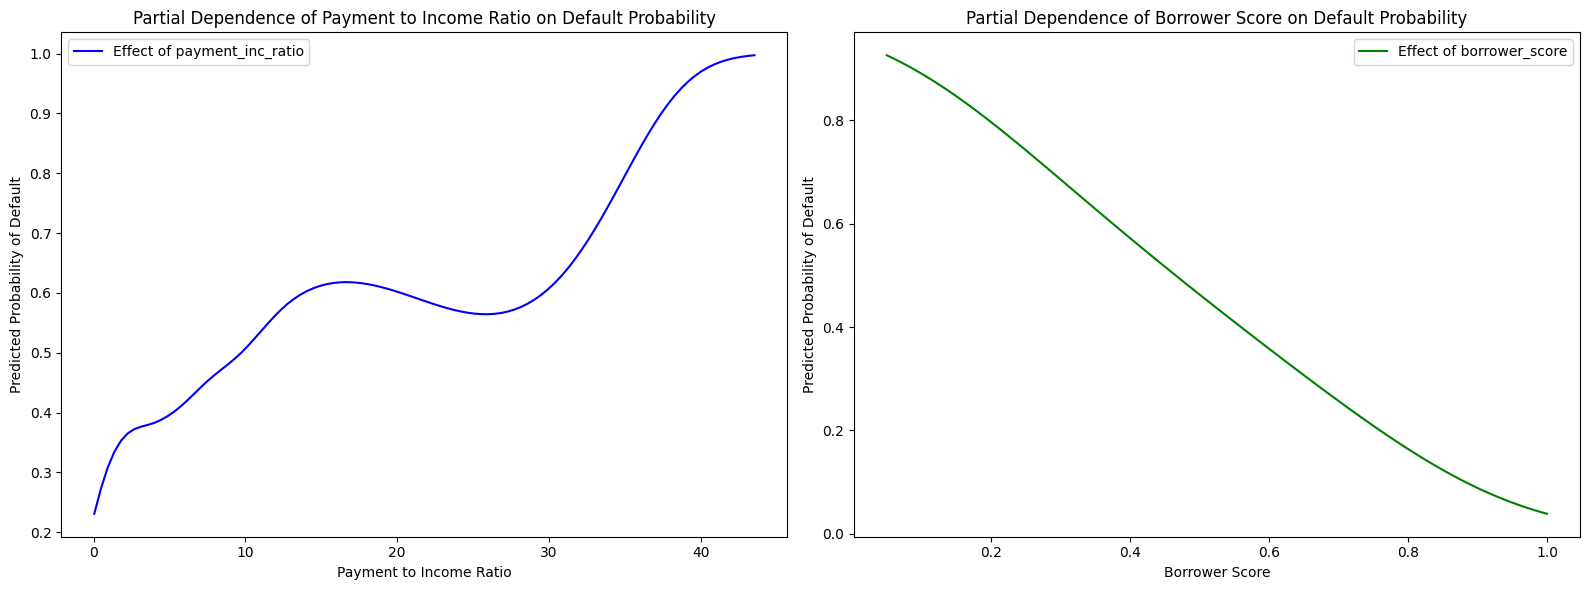

In [39]:
import statsmodels.api as sm
from patsy import dmatrix

# Generate sequences of values for each predictor to cover their entire range
payment_inc_ratio_vals = np.linspace(loan_data['payment_inc_ratio'].min(), loan_data['payment_inc_ratio'].max(), 100)
borrower_score_vals = np.linspace(loan_data['borrower_score'].min(), loan_data['borrower_score'].max(), 100)

# Create DataFrames for plotting payment_inc_ratio
plot_data_payment = pd.DataFrame({'payment_inc_ratio': payment_inc_ratio_vals})
for col in ['purpose_', 'home_', 'emp_len_', 'borrower_score']:
    if col in loan_data.columns:
        plot_data_payment[col] = loan_data[col].mode()[0]

# Generate B-spline terms for payment_inc_ratio
bs_payment = dmatrix("bs(payment_inc_ratio, df=8, include_intercept=False)",
                     {"payment_inc_ratio": payment_inc_ratio_vals}, return_type='dataframe')
plot_data_payment = pd.concat([plot_data_payment, bs_payment], axis=1)

# Create DataFrames for plotting borrower_score
plot_data_borrower = pd.DataFrame({'borrower_score': borrower_score_vals})
for col in ['purpose_', 'home_', 'emp_len_', 'payment_inc_ratio']:
    if col in loan_data.columns:
        plot_data_borrower[col] = loan_data[col].mode()[0]

# Generate B-spline terms for borrower_score
bs_borrower = dmatrix("bs(borrower_score, df=3, include_intercept=False)",
                      {"borrower_score": borrower_score_vals}, return_type='dataframe')
plot_data_borrower = pd.concat([plot_data_borrower, bs_borrower], axis=1)

# Predict outcomes for both plots
payment_preds = results.predict(plot_data_payment)
borrower_preds = results.predict(plot_data_borrower)

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Create two subplots side by side

# Plot for payment_inc_ratio
axes[0].plot(payment_inc_ratio_vals, payment_preds, color='b', label='Effect of payment_inc_ratio')
axes[0].set_xlabel('Payment to Income Ratio')
axes[0].set_ylabel('Predicted Probability of Default')
axes[0].set_title('Partial Dependence of Payment to Income Ratio on Default Probability')
axes[0].legend()

# Plot for borrower_score
axes[1].plot(borrower_score_vals, borrower_preds, color='g', label='Effect of borrower_score')
axes[1].set_xlabel('Borrower Score')
axes[1].set_ylabel('Predicted Probability of Default')
axes[1].set_title('Partial Dependence of Borrower Score on Default Probability')
axes[1].legend()

plt.tight_layout()  # Adjust layout to ensure everything fits well
plt.show()


### Residuals

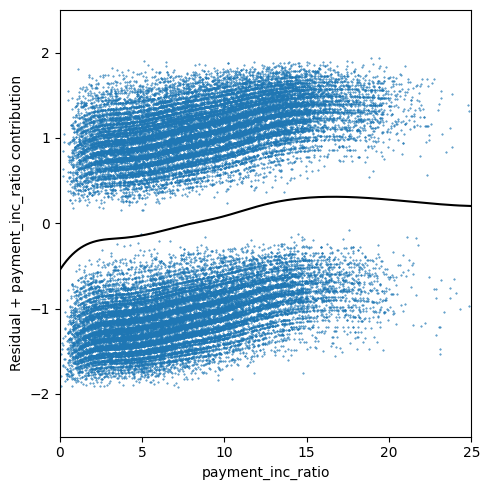

In [41]:
from statsmodels.genmod.generalized_linear_model import GLMResults

# Function to create a partial residual plot for a given feature
def partialResidualPlot(model, df, outcome, feature, fig, ax):
    # Convert outcome labels to numeric values for plotting
    y_actual = [0 if s == 'default' else 1 for s in df[outcome]]  # Encode 'default' as 0, 'paid off' as 1

    # Get predicted values from the model for the actual dataset
    y_pred = model.predict(df)  # Predict using the original model

    # Create copies of the model parameters for modifications
    org_params = model.params.copy()   # Keep a copy of the original model parameters
    zero_params = model.params.copy()  # Copy to modify

    # Set model parameters of all features except the selected feature to 0
    for i, name in enumerate(zero_params.index):
        if feature in name:        # Skip setting parameters for the selected feature to zero
            continue
        zero_params.iloc[i] = 0.0  # Set the parameter value to 0

    # Initialize the model with parameters set to zero for other features
    model.initialize(model.model, zero_params)  # Update the model to have only the selected feature's parameter
    feature_prediction = model.predict(df)      # Predict using modified parameters (only the feature contributes)

    # Calculate the partial effect of the feature on the outcome
    ypartial = -np.log(1 / feature_prediction - 1)  # Transform prediction to log-odds
    ypartial = ypartial - np.mean(ypartial)         # Center the partial prediction to mean 0

    # Reinitialize the model with original parameters
    model.initialize(model.model, org_params)  # Restore the model to its original parameters

    # Create a DataFrame to hold the values for plotting
    results = pd.DataFrame({
        'feature': df[feature],                # Feature values (e.g., payment_inc_ratio)
        'residual': -2 * (y_actual - y_pred),  # Calculate residuals
        'ypartial': ypartial / 2,              # Adjusted partial effect values
    })
    results = results.sort_values(by=['feature'])  # Sort by feature values for smooth plotting

    # Create scatter plot for residuals and line plot for partial effects
    ax.scatter(results.feature, results.residual, marker=".", s=72./fig.dpi)  # Scatter plot of feature vs residuals
    ax.plot(results.feature, results.ypartial, color='black')                 # Line plot of feature vs partial effect
    ax.set_xlabel(feature)                                                    # Label x-axis with feature name
    ax.set_ylabel(f'Residual + {feature} contribution')                       # Label y-axis with description of plotted value
    return ax                                                                 # Return the axis object

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(5, 5))

# Generate a partial residual plot for the 'payment_inc_ratio' feature
partialResidualPlot(results, loan_data, 'outcome', 'payment_inc_ratio', fig, ax)
ax.set_xlim(0, 25)      # Set x-axis limits for better visibility
ax.set_ylim(-2.5, 2.5)  # Set y-axis limits for better visibility

# Adjust layout and show the plot
plt.tight_layout()  # Ensure labels and plot elements are properly fitted
plt.show()          # Display the plot

*Partial residuals from logistic regression*

The residuals form two distinct horizontal bands: one above and one below zero. This separation suggests that there are two major groupings of residual values, potentially corresponding to different classes (e.g., default and paid off). The graph may be indicating a strong classification boundary where the model differentiates between these two outcomes, which aligns with the logistic regression approach.

The black line has a slight positive slope, indicating that as payment_inc_ratio increases, the model’s contribution to the probability of default also increases slightly. This makes sense intuitively: higher payment-to-income ratios indicate a higher proportion of income going toward payments, which would make it harder for borrowers to make payments, hence increasing the likelihood of default.

# Evaluating Classification Models
### Confusion Matrix

In [45]:
# Predict class labels for the data using the fitted logistic regression model
pred = logit_reg.predict(X)                 # Predict 'default' or 'paid off' for each observation

# Convert predicted and true values to Boolean, representing 'default'
pred_y = logit_reg.predict(X) == 'default'  # Boolean series where True represents 'default' predictions
true_y = y == 'default'                     # Boolean series where True represents 'default' actual values

# Calculate the four confusion matrix components
true_pos = true_y & pred_y    # True Positives: predicted 'default' and actual is 'default'
true_neg = ~true_y & ~pred_y  # True Negatives: predicted 'paid off' and actual is 'paid off'
false_pos = ~true_y & pred_y  # False Positives: predicted 'default' but actual is 'paid off'
false_neg = true_y & ~pred_y  # False Negatives: predicted 'paid off' but actual is 'default'

# Create the confusion matrix as a DataFrame
conf_mat = pd.DataFrame(
    [[np.sum(true_pos), np.sum(false_neg)],        # First row: True Positives, False Negatives
     [np.sum(false_pos), np.sum(true_neg)]],       # Second row: False Positives, True Negatives
    index=['Y = default', 'Y = paid off'],         # Actual values (rows)
    columns=['Yhat = default', 'Yhat = paid off']  # Predicted values (columns)
)

# Display the confusion matrix
conf_mat

,Yhat = default,Yhat = paid off
Y = default,14336,8335
Y = paid off,8148,14523


In [46]:
print(confusion_matrix(y, logit_reg.predict(X)))

[[14336  8335]
 [ 8148 14523]]


In [47]:
classificationSummary(y, logit_reg.predict(X), class_names=logit_reg.classes_)

Confusion Matrix (Accuracy 0.6365)

         Prediction
  Actual  default paid off
 default    14336     8335
paid off     8148    14523


### Precision, Recall, and Specificity

In [49]:
conf_mat = confusion_matrix(y, logit_reg.predict(X))

print('  Precision:', conf_mat[0, 0] / sum(conf_mat[:, 0]))
print('     Recall:', conf_mat[0, 0] / sum(conf_mat[0, :]))
print('Specificity:', conf_mat[1, 1] / sum(conf_mat[1, :]))

  Precision: 0.6376089663760897
     Recall: 0.6323496978518812
Specificity: 0.6405981209474659


In [50]:
precision_recall_fscore_support(y, logit_reg.predict(X), labels=['default', 'paid off'])

(array([0.63760897, 0.63535742]),
 array([0.6323497 , 0.64059812]),
 array([0.63496844, 0.63796701]),
 array([22671, 22671], dtype=int64))

#### Summary of Each Metric:

| Metric       | 'default' Value | 'paid off' Value | Explanation                                                                                          |
|--------------|-----------------|------------------|------------------------------------------------------------------------------------------------------|
| **Precision**| 0.6376          | 0.6354           | Proportion of correctly predicted instances out of predicted positive instances for each class.      |
| **Recall**   | 0.6323          | 0.6406           | Proportion of correctly predicted instances out of the actual positive instances for each class.     |
| **F1-Score** | 0.6349          | 0.6380           | Harmonic mean of precision and recall. Higher value indicates a good balance of precision and recall.|
| **Support**  | 22671           | 22671            | Total number of instances in each class in the dataset.                                              |


### ROC Curve
You can see that there is a trade-off between recall and specificity. Capturing more 1s
generally means misclassifying more 0s as 1s. The ideal classifier would do an excellent job of classifying the 1s, without misclassifying more 0s as 1s.

The metric that captures this trade-off is the “Receiver Operating Characteristics”
curve, usually referred to as the ROC curve. The ROC curve plots recall (sensitivity)
on the y-axis against specificity on the x-axis.4 The ROC curve shows the trade-off
between recall and specificity as you change the cutoff to determine how to classify a
record.

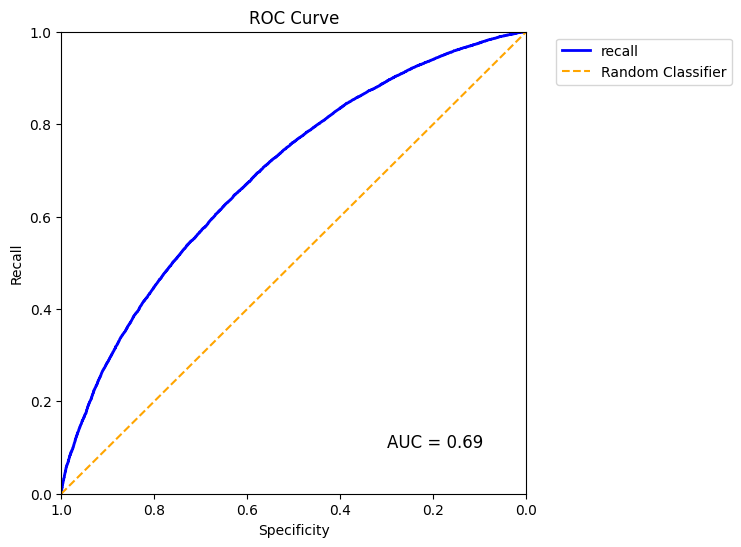

In [53]:
from sklearn.metrics import roc_curve, auc

# Calculate the False Positive Rate (FPR), True Positive Rate (TPR), and thresholds for ROC
fpr, tpr, thresholds = roc_curve(y, logit_reg.predict_proba(X)[:, 0], pos_label='default')

# Create a DataFrame to store Recall (TPR) and Specificity (1 - FPR) values
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

# Create the plot for ROC curve with a customized figure size
fig, ax = plt.subplots(figsize=(6, 6)) 

# Plot recall vs specificity for the ROC curve
roc_df.plot(x='specificity', y='recall', ax=ax, legend=False, color='blue', linewidth=2)        # Set line color and width for clarity

# Plot the diagonal line representing random classifier performance (baseline)
ax.plot((1, 0), (0, 1), color='orange', linestyle='--', linewidth=1.5, label='Random Classifier')  # Dashed red line for baseline performance

# Set axis limits for recall and specificity
ax.set_ylim(0, 1)  # Recall ranges from 0 to 1
ax.set_xlim(1, 0)  # Specificity ranges from 1 to 0 (reverse for ROC)

# Set labels for axes
ax.set_xlabel('Specificity')  # Label x-axis
ax.set_ylabel('Recall')       # Label y-axis
ax.set_title('ROC Curve')     # Add title for the plot

# Calculate the Area Under the Curve (AUC) for ROC and add to plot
roc_auc = auc(fpr, tpr)       # Calculate the AUC
ax.text(0.3, 0.1, f'AUC = {roc_auc:.2f}', fontsize=12, color='black')  # Display AUC value on the plot

# Add a legend outside of the plot for better visualization
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the ROC curve
plt.show() 

#### AUC

In [55]:
# We can calculate AUC in both ways

# Computes the AUC using the trapezoidal rule: 
print(np.sum(roc_df.recall[:-1] * np.diff(1 - roc_df.specificity)))

# Calculates AUC by integrating the ROC curve internally:
print(roc_auc_score([1 if yi == 'default' else 0 for yi in y], logit_reg.predict_proba(X)[:, 0]))  # More robust

0.6917107972342917
0.6917108750592036


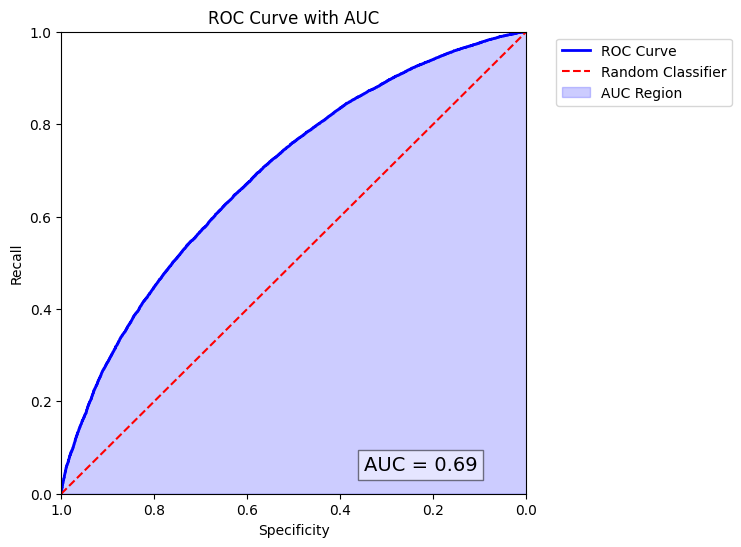

In [56]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate the False Positive Rate (FPR), True Positive Rate (TPR), and thresholds for ROC
fpr, tpr, thresholds = roc_curve(y, logit_reg.predict_proba(X)[:, 0], pos_label='default')

# Create a DataFrame to store Recall (TPR) and Specificity (1 - FPR) values
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

# Create the plot for ROC curve with a larger customized figure size
fig, ax = plt.subplots(figsize=(6, 6))  

# Plot the recall vs. specificity curve
ax.plot(roc_df['specificity'], roc_df['recall'], color='blue', linewidth=2, label='ROC Curve')  # Set line color and width for better visibility

# Plot the diagonal line representing random classifier performance (baseline)
ax.plot((1, 0), (0, 1), color='red', linestyle='--', linewidth=1.5, label='Random Classifier')  # Dashed line for baseline

# Fill the area under the ROC curve for emphasis
ax.fill_between(roc_df['specificity'], 0, roc_df['recall'], color='blue', alpha=0.2, label='AUC Region')  # Fill area to emphasize AUC

# Set axis limits for recall and specificity
ax.set_ylim(0, 1)  # Recall ranges from 0 to 1
ax.set_xlim(1, 0)  # Specificity ranges from 1 to 0 (reverse axis for ROC)

# Set labels for axes and title
ax.set_xlabel('Specificity')  # Set x-axis label
ax.set_ylabel('Recall')  # Set y-axis label
ax.set_title('ROC Curve with AUC')  # Add a title for the ROC Curve

# Calculate and display the Area Under the Curve (AUC) value
roc_auc = auc(fpr, tpr)  # Calculate AUC using sklearn's auc function
ax.text(0.35, 0.05, f'AUC = {roc_auc:.2f}', fontsize=14, color='black', bbox=dict(facecolor='white', alpha=0.5))  # Display AUC on plot

# Add a legend to describe the plot components
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the improved ROC curve
plt.show()  

# Strategies for Imbalanced Data
### Undersampling

In [58]:
# Read the CSV file from the .gz format
full_train_set = pd.read_csv('full_train_set.csv.gz')

# Display the first few rows to check if it loaded properly
full_train_set.head()

,status,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,home_ownership,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_
0,Fully Paid,5000,36 months,24000,27.65,8.14350,13648.0,83.7,credit_card,RENT,1,1,3,5.4,paid off,11,credit_card,RENT,> 1 Year
1,Charged Off,2500,60 months,30000,1.00,2.39320,1687.0,9.4,car,RENT,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year
2,Fully Paid,2400,36 months,12252,8.72,8.25955,2956.0,98.5,small_business,RENT,1,1,2,5.0,paid off,11,small_business,RENT,> 1 Year
3,Fully Paid,10000,36 months,49200,20.00,8.27585,5598.0,21.0,other,RENT,1,1,10,4.2,paid off,11,other,RENT,> 1 Year
4,Fully Paid,5000,36 months,36000,11.20,5.21533,7963.0,28.3,wedding,RENT,1,1,9,6.8,paid off,4,other,RENT,> 1 Year


In [59]:
print(full_train_set.shape)

(119987, 19)


In [60]:
perc_loan_default = 100 * np.mean(full_train_set.outcome == 'default')
print(f'Percentage of loans in default: {perc_loan_default.round(2)}%')

Percentage of loans in default: 18.89%


In [61]:
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_', 'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'

# Create dummy variables for categorical predictors in the dataset (drop the first category to avoid multicollinearity)
X = pd.get_dummies(full_train_set[predictors], prefix='', prefix_sep='', drop_first=True, dtype=int)

# Extract the outcome variable from the dataset
y = full_train_set[outcome]

# Logistic Regression model
full_model = LogisticRegression(penalty='l2',        # Use L2 regularization (ridge penalty)
                                C=1e42,              # A very large value for C (almost a standard logistic regression)
                                solver='liblinear')  # Use 'liblinear' solver, suitable for smaller datasets

# Fit the logistic regression model
full_model.fit(X, y)

perc_loan_predicted__default = 100 * np.mean(full_model.predict(X) == 'default')
print(f'Percentage of loans predicted to default: {perc_loan_predicted__default.round(2)}%')

Percentage of loans predicted to default: 0.79%


In [62]:
compare_proportions =  (np.mean(full_train_set.outcome == 'default') / 
                        np.mean(full_model.predict(X) == 'default')).round(2)

print(f'Proportion Comparison between "Percentage of loans in default" and "Percentage of loans predicted to default": {compare_proportions}')

Proportion Comparison between "Percentage of loans in default" and "Percentage of loans predicted to default": 24.07


### Oversampling and Up/Down Weighting

One criticism of the undersampling method is that it throws away data and is not
using all the information at hand. If you have a relatively small data set, and the rarer
class contains a few hundred or a few thousand records, then undersampling the
dominant class has the risk of throwing out useful information. In this case, instead
of downsampling the dominant case, you should oversample (upsample) the rarer
class by drawing additional rows with replacement (bootstrapping).

You can achieve a similar effect by weighting the data. Many classification algorithmstake a weight argument that will allow you to up/down weight the data. 

The weights for loans that default are set to 1/p, where p is the probability of default.
The nondefaulting loans have a weight of 1. The sums of the weights for the defauling loans and nondefaulting loans are roughly equal.‐

In [65]:
# Calculate weight for 'default' class (inverse of its proportion)
default_wt = 1 / np.mean(full_train_set.outcome == 'default')  

# Assign weight to each observation (higher weight for 'default')
wt = [default_wt if outcome == 'default' else 1 for outcome in full_train_set.outcome]  

# Logistic Regression model
full_model = LogisticRegression(penalty="l2",        # Use L2 regularization (ridge penalty)
                                C=1e42,              # Large value for C (minimize regularization)
                                solver='liblinear')  # Use 'liblinear' solver (good for smaller datasets)

# Fit the logistic regression model with class weights
full_model.fit(X, y, wt)                             # custom weights to handle class imbalance

predicted__default_weighting = 100 * np.mean(full_model.predict(X) == 'default')
print(f'Percentage of loans predicted to default (weighting): {predicted__default_weighting.round(2)}%')

Percentage of loans predicted to default (weighting): 62.34%


From the code above:
```Python
# Calculate weight for 'default' class (inverse of its proportion)
default_wt = 1 / np.mean(full_train_set.outcome == 'default')  

# Assign weight to each observation (higher weight for 'default')
wt = [default_wt if outcome == 'default' else 1 for outcome in full_train_set.outcome] 
```
* **The first line** calculates a weight for the 'default' class, which is the inverse of its proportion in the dataset. If 'default' is rare, the weight will be high.
* **The second line** creates a list of weights for all observations, where loans with a 'default' outcome get a higher weight compared to 'paid off' loans.
* **Overall**, this weighting scheme is intended to address the class imbalance by making the 'default' class more prominent during model training, thereby improving the model's ability to correctly identify and predict defaults.

### Data Generation

By creating new records that are similar but not identical to existing
records, the algorithm has a chance to learn a more robust set of rules. This notion is
similar in spirit to ensemble statistical models such as boosting and bagging

The idea gained traction with the publication of the SMOTE algorithm, which stands
for “Synthetic Minority Oversampling Technique.” The SMOTE algorithm finds a
record that is similar to the record being upsampled and creates a synthetic record that is a randomly weighted average of the
original record and the neighboring record, where the weight is generated separately
for each predictor. The number of synthetic oversampled records created depends on
the oversampling ratio required to bring the data set into approximate balance with
respect to outcome classes.

ADASYN (Adaptive Synthetic Sampling) is a data augmentation technique used for handling class imbalance in datasets, specifically in classification problems. It is a variant of the Synthetic Minority Over-sampling Technique (SMOTE), and its primary goal is to generate synthetic data points for the minority class to balance the dataset, making it more suitable for machine learning models.

In [69]:
# SMOTE =======================================================
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
pld_smote = 100 * np.mean(y_resampled == 'default').round(2)
print(f'Percentage of loans in default (SMOTE resampled): {pld_smote}%') 

full_model = LogisticRegression(penalty="l2", 
                                C=1e42, 
                                solver='liblinear')

full_model.fit(X_resampled, y_resampled)

pred_pld_smote = 100 * np.mean(full_model.predict(X) == 'default')
print(f'Percentage of loans predicted to default (SMOTE): {pred_pld_smote.round(2)}%')
print()

# ADASYN ======================================================
X_resampled, y_resampled = ADASYN().fit_resample(X, y)
ada_pld_smote = 100 * np.mean(y_resampled == 'default').round(2)
print(f'Percentage of loans in default (ADASYN resampled): {ada_pld_smote}%')

full_model = LogisticRegression(penalty="l2", 
                                C=1e42, 
                                solver='liblinear')

full_model.fit(X_resampled, y_resampled)

ada_pred = 100 * np.mean(full_model.predict(X) == 'default')
print(f'Percentage of loans predicted to default (ADASYN): {ada_pred.round(2)}%')

Percentage of loans in default (SMOTE resampled): 50.0%
Percentage of loans predicted to default (SMOTE): 29.6%

Percentage of loans in default (ADASYN resampled): 49.0%
Percentage of loans predicted to default (ADASYN): 27.6%


#### Key Differences Between ADASYN and SMOTE:
Adaptive Sampling:

* SMOTE creates synthetic data points for **all** minority instances equally.
* ADASYN, on the other hand, focuses more on **harder-to-learn** minority instances, adapting the sampling process to the dataset's specific characteristics.

Focus on Difficult Areas:

* ADASYN places greater emphasis on **boundary areas** or regions with high overlap between classes, helping to improve classification boundaries.
* This makes ADASYN particularly useful in scenarios where the decision boundary between classes is not well-defined.

#### Advantages of ADASYN:
Improved Model Performance:
* By focusing on areas where the classifier is struggling, ADASYN can significantly improve the recall of the minority class, reducing false negatives.

Adaptive Nature:
* The adaptive generation of synthetic samples allows the model to better capture decision boundaries, especially when the minority class distribution is complex or overlapping with the majority class.
#### Disadvantages of ADASYN:
Increased Complexity:
* The algorithm adds complexity to the dataset, potentially leading to overfitting in some cases, especially if the synthetic data introduces too much noise.
  
More Computation:
* The process of identifying hard-to-classify instances and generating synthetic data is more computationally intensive compared to SMOTE.

# Exploring the Predictions

In [73]:
# Load the CSV data into a DataFrame
url2 = ('https://raw.githubusercontent.com/arvindbetrabet/Practical_Statistics_for_Data_Scientists/refs/heads/master/data/loan3000.csv')  
loan3000 = pd.read_csv(url2)

loan3000.head()

,Unnamed: 0,outcome,purpose_,dti,borrower_score,payment_inc_ratio
0,32109,paid off,debt_consolidation,21.23,0.40,5.11135
1,16982,default,credit_card,15.49,0.40,5.43165
2,25335,paid off,debt_consolidation,27.30,0.70,9.23003
3,34580,paid off,major_purchase,21.11,0.40,2.33482
4,14424,default,debt_consolidation,16.46,0.45,12.10320


In [74]:
predictors = ['borrower_score', 'payment_inc_ratio']  # Define the predictor variables (features)
outcome = 'outcome'                                   # Define the target variable (outcome to be predicted)

X = loan3000[predictors]  # Extract predictor variables from the dataset
y = loan3000[outcome]     # Extract outcome variable from the dataset

# Decision Tree Classifier
loan_tree = DecisionTreeClassifier(random_state=1,               # Set random state for reproducibility
                                   criterion='entropy',          # Use entropy as the splitting criterion
                                   min_impurity_decrease=0.003)  # Minimum impurity decrease for a split to occur

loan_tree.fit(X, y)  # Fit the decision tree model to the predictor and outcome variables

# Linear Discriminant Analysis (LDA)
loan_lda = LinearDiscriminantAnalysis()  # Instantiate LDA model for dimension reduction and classification
loan_lda.fit(X, y)                       # Fit LDA to the predictor and outcome variables

# Logistic Regression model
logit_reg = LogisticRegression(penalty="l2",           # Use L2 regularization (ridge penalty)
                               solver='liblinear')     # Use 'liblinear' solver (suitable for small datasets)

logit_reg.fit(X, y)  # Fit logistic regression model to the predictor and outcome variables

# Generalized Additive Model (GAM) with smooth terms for each predictor
gam = LinearGAM(s(0) + s(1))  # Instantiate GAM with smooth functions for both features (borrower_score and payment_inc_ratio)
print(gam.gridsearch(X.values, [1 if yi == 'default' else 0 for yi in y]))  # Perform grid search to find optimal smoothing parameters

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + intercept, 
   tol=0.0001, verbose=False)


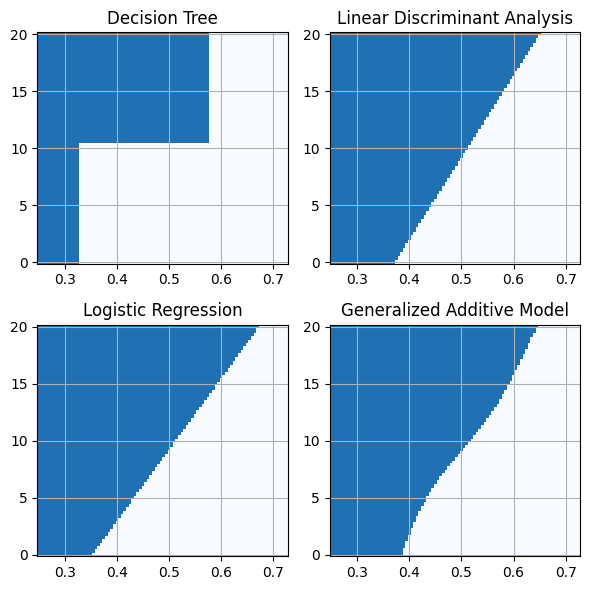

In [75]:
# Dictionary to store each model with its corresponding name
models = {
    'Decision Tree': loan_tree,                   # Decision Tree Classifier
    'Linear Discriminant Analysis': loan_lda,     # Linear Discriminant Analysis (LDA)
    'Logistic Regression': logit_reg,             # Logistic Regression model
    'Generalized Additive Model': gam,            # Generalized Additive Model (GAM)
}

# Create a figure with 2 rows and 2 columns of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6, 6))

# Define a range of values for the x and y axes to create the decision boundary grid
xvalues = np.arange(0.25, 0.73, 0.005)            # Borrower score values (x-axis range)
yvalues = np.arange(-0.1, 20.1, 0.1)              # Payment income ratio values (y-axis range)

# Create a meshgrid from the x and y values to represent all combinations of values for plotting
xx, yy = np.meshgrid(xvalues, yvalues)            # Create a grid of borrower scores and payment ratios

# Create a DataFrame from the meshgrid values for prediction with each model
X = pd.DataFrame({
    'borrower_score': xx.ravel(),                 # Flatten the meshgrid and use as input feature 'borrower_score'
    'payment_inc_ratio': yy.ravel(),              # Flatten the meshgrid and use as input feature 'payment_inc_ratio'
})

# Initialize an empty dictionary to store decision boundaries
boundary = {}

# Iterate through each model to create decision boundary plots
for n, (title, model) in enumerate(models.items()):
    ax = axes[n // 2, n % 2]                                         # Determine the current axis for plotting in 2x2 layout

    predict = model.predict(X)                                       # Use the current model to predict outcomes for the generated data points

    # Transform prediction to binary form depending on model type
    if 'Generalized' in title:
        Z = np.array([1 if z > 0.5 else 0 for z in predict])         # For GAM, convert probabilities to binary (threshold = 0.5)
    else:
        Z = np.array([1 if z == 'default' else 0 for z in predict])  # Convert prediction to binary (1 for 'default', 0 otherwise)

    Z = Z.reshape(xx.shape)                                          # Reshape predictions to match the shape of the meshgrid for plotting

    # Find boundary values (y-value at the point where prediction changes from 0 to 1)
    boundary[title] = yvalues[np.argmax(Z > 0, axis=0)]              # Find the index where prediction switches to 1 (decision boundary)
    boundary[title][Z[-1, :] == 0] = yvalues[-1]                     # Fill boundary with the highest y-value if no change is detected

    # Plot the decision boundary using pcolormesh
    c = ax.pcolormesh(xx, yy, Z, cmap='Blues', vmin=0.1, vmax=1.3, shading='auto')  # Color mesh to show decision regions
    ax.set_title(title)                                              # Set the title for the subplot to indicate the model used
    ax.grid(True)                                                    # Add grid lines for better visualization of the boundaries

# Adjust layout to avoid overlap of subplots
plt.tight_layout()
plt.show() 

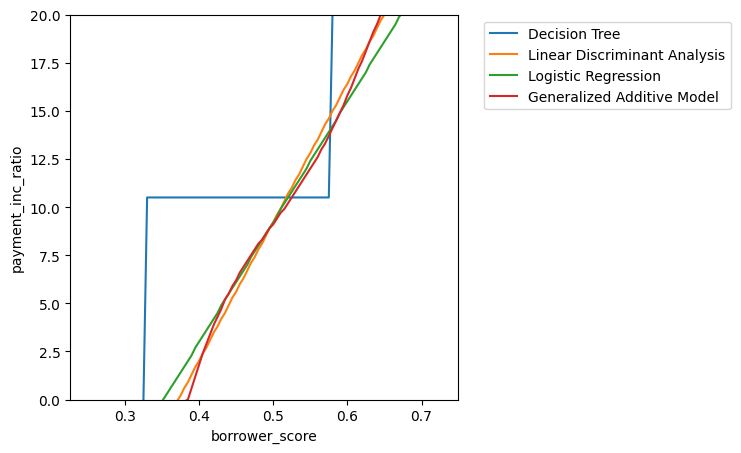

In [76]:
boundary['borrower_score'] = xvalues                  # Assign xvalues (borrower score) as a new key

boundaries = pd.DataFrame(boundary)                   # Create a DataFrame from the boundary dictionary

fig, ax = plt.subplots(figsize=(5, 5))                # Set figure size to better visualize decision boundaries

boundaries.plot(x='borrower_score', ax=ax)            # Use 'borrower_score' as the x-axis to plot all model boundaries

ax.set_ylabel('payment_inc_ratio')                    # Label the y-axis as 'payment_inc_ratio' (loan feature being predicted)
ax.set_ylim(0, 20)                                    # Limit the y-axis values to the range from 0 to 20

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Add a legend to describe the plot components

plt.show()                                            # Show the plot containing the decision boundaries for all models

*Comparison of the classification rules for four different methods*